This file containt the integration of all the modules of the project. It has the flooded area calculation using NDWI and number of buildings calculation using Laplacian of Gaussian
(LoG) method.

In [ ]:
#@title
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.5 MB/s eta 0:00:00
Mounted at /content/gdrive


In [ ]:
#@title
from fastai.vision.all import *
from fastai.data.all import *
from fastai.imports import *
from fastai.vision.core import *
from fastai import metrics
import scipy
from scipy import ndimage

In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title
def get_tuple_files(path):
    files = get_image_files(path)
    files = files.filter(lambda f: f.name.endswith('vhr.tif'),negate=False)
    return files


In [ ]:
#@title
def label_func(x):
      return str(x.parents[0]/x.stem[0:23])+"_mask_build.tif";

In [ ]:
#@title
model_build= load_learner(Path('/content/drive/My Drive/patch-building.pkl'),cpu = True)


model_flood= load_learner(Path('/content/drive/My Drive/patch-flooded.pkl'),cpu = True)

In [ ]:
#@title
up=fastbook.widgets.FileUpload()
up

FileUpload(value={}, description='Upload')

In [ ]:
#@title
out=fastbook.widgets.Output()
bt_in=fastbook.widgets.Button(description="Input")
bt=fastbook.widgets.Button(description="Total Buildings")
bt_fld=fastbook.widgets.Button(description="Damaged Buildings")


Image Selection

In [ ]:
#@title
ImgPath = "/content/drive/My Drive/Demo/flood1.tif"
ImageUsed = PILImage.create(ImgPath)
TotalBuild = ImageUsed;
TotalFlood = ImageUsed;

In [ ]:
#@title
def on_click_input(change):
  im=ImageUsed
  z=im.reshape(1024,1024,resample=3)

  z=image2tensor(z)
  z=z[:,0:512,0:512]
  z=z.permute((1,2,0))
  im=PILImage.create(z.cpu().numpy())

  im.show()




bt_in.on_click(on_click_input)

def on_click_flood(change):
    print("DAMAGED BUILDINGS")
    im=ImageUsed
    z=im.reshape(1024,1024,resample=3)

    z=image2tensor(z)
    z=z[:,0:512,0:512]
    z=z.permute((1,2,0))
    im=PILImage.create(z.cpu().numpy())
    PILMask.create(model_flood.predict(im)[0])
    PILMask.create(model_flood.predict(im)[0]).show()
    TotalFlood = PILMask.create(model_flood.predict(im)[0])
    plt.imsave("/content/drive/MyDrive/Demo/damagesaved.png",TotalFlood)
bt_fld.on_click(on_click_flood)


def on_click_segmen(change):
    print("TOTAL BUILDINGS")
    im=ImageUsed
    z=im.reshape(1024,1024,resample=3)

    z=image2tensor(z)
    z=z[:,0:512,0:512]
    z=z.permute((1,2,0))
    im=PILImage.create(z.cpu().numpy())
    PILMask.create(model_build.predict(im)[0]).show()
    TotalBuild = PILMask.create(model_build.predict(im)[0])
    plt.imsave("/content/drive/MyDrive/Demo/totalsaved.png",TotalBuild)

bt.on_click(on_click_segmen)


In [ ]:
#@title
lb_ch=fastbook.widgets.Label(value="Choose Image File")

In [ ]:
#@title
fastbook.widgets.VBox([fastbook.widgets.Label('Select the map image'),bt_in,bt,bt_fld,lb_ch])

## Building Counting

In [ ]:
#@title
from matplotlib import pyplot as plt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
from skimage.color import rgb2gray
import glob
from skimage.io import imread


InputImage : RBC.jpg


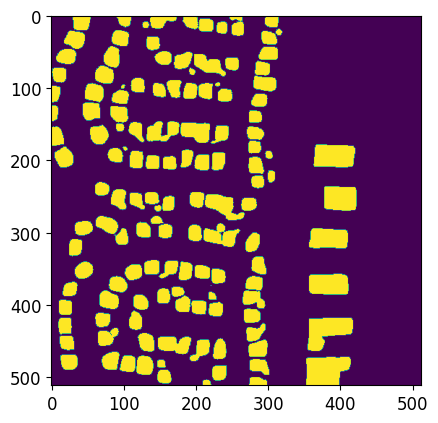

In [ ]:

example_file = glob.glob(r"/content/drive/MyDrive/Demo/buildcount0.png")[0]
#example_file = glob.glob(r"/content/drive/MyDrive/Demo/damagesaved.png")[0]
plt.show(example_file)
cm_gray = plt.get_cmap()
im = imread(example_file, as_gray=True)
plt.imshow(im, cmap=cm_gray)
print("InputImage : RBC.jpg")

plt.show()

In [ ]:
totdamage = 0

Number of Flooded Buildings:  135


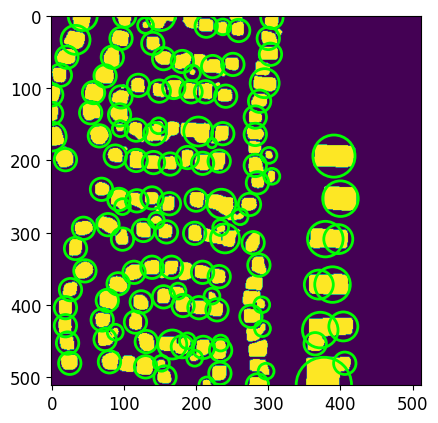

In [ ]:


blobs_log = blob_log(im, max_sigma=30, num_sigma=10, threshold=.38)

blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
numrows = len(blobs_log)
print("Number of Flooded Buildings: " ,numrows)
totdamage = numrows
fig, ax = plt.subplots(1, 1)
plt.imshow(im, cmap=cm_gray)
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r+5, color='lime', linewidth=2, fill=False)
    ax.add_patch(c)
plt.show()


In [ ]:
example_file = glob.glob(r"/content/drive/MyDrive/Demo/buildcount0.png")[0]
#example_file = glob.glob(r"/content/drive/MyDrive/Demo/totalsaved.png")[0]
plt.show(example_file)
cm_gray = plt.get_cmap()
im = imread(example_file, as_gray=True)
#plt.imshow(im, cmap=cm_gray)
print("InputImage : RBC.jpg")


#plt.show()

InputImage : RBC.jpg


In [ ]:
totbuild =0;

In [ ]:


blobs_log = blob_log(im, max_sigma=30, num_sigma=10, threshold=.3)

blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
numrows = len(blobs_log)
print("Number of Total Buildings: " ,numrows)
totbuild = numrows
#fig, ax = plt.subplots(1, 1)
#plt.imshow(im, cmap=cm_gray)
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r+5, color='lime', linewidth=2, fill=False)
    ax.add_patch(c)
#plt.show()


Number of Total Buildings:  190


## Damaged Building Ratio

In [ ]:
#@title
Buidratio = totdamage/totbuild
print("Damaged Building Ratio: ", Buidratio)

Damaged Building Ratio:  0.7105263157894737


## Flooded Area Calculation

In [ ]:
!pip install earthpy gdal seaborn geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 60.7 MB/s eta 0:00:00


In [ ]:
!pip install gdal

In [ ]:
import numpy as np
from numpy import nan_to_num, subtract, add, divide, multiply
from osgeo import gdal, gdalconst
#from gdal import GetDriverByName


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/Dataset/All_band_images/Post/08_30'

/content/drive/.shortcut-targets-by-id/1XtvRf34AeAk9diAWzzO2_fRZQBZJw_PE/Dataset/All_band_images/Post/08_30


In [ ]:
from glob import glob
import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib import colors
import matplotlib as mpl
import seaborn as sns

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

#import gdal

import geopandas as gpd
from shapely.geometry import mapping, box

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

In [ ]:
all_sentinel_bands = glob("/content/drive/MyDrive/Dataset/All_band_images/Pre/*B[0-1]*.tiff")

all_sentinel_bands.sort()
all_sentinel_bands


['/content/drive/MyDrive/Dataset/All_band_images/Pre/2017-08-20-00_00_2017-08-20-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 '/content/drive/MyDrive/Dataset/All_band_images/Pre/2017-08-20-00_00_2017-08-20-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 '/content/drive/MyDrive/Dataset/All_band_images/Pre/2017-08-20-00_00_2017-08-20-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 '/content/drive/MyDrive/Dataset/All_band_images/Pre/2017-08-20-00_00_2017-08-20-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 '/content/drive/MyDrive/Dataset/All_band_images/Pre/2017-08-20-00_00_2017-08-20-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 '/content/drive/MyDrive/Dataset/All_band_images/Pre/2017-08-20-00_00_2017-08-20-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 '/content/drive/MyDrive/Dataset/All_band_images/Pre/2017-08-20-00_00_2017-08-20-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 '/content/drive/MyDrive/Dataset/All_band_images/Pre/2017-08-20-00_00_2017-08-20-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 '/content/drive/MyDrive/Dataset/All_band_images

Pre Flood

In [ ]:
all_sentinel_bands[2], all_sentinel_bands[7]

('/content/drive/MyDrive/Dataset/All_band_images/Pre/2017-08-20-00_00_2017-08-20-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 '/content/drive/MyDrive/Dataset/All_band_images/Pre/2017-08-20-00_00_2017-08-20-23_59_Sentinel-2_L2A_B08_(Raw).tiff')

In [ ]:
with rio.open(all_sentinel_bands[2]) as  f1:
    green_b = reshape_as_image(f1.read())

with rio.open(all_sentinel_bands[7]) as  f2:
    nir_b = reshape_as_image(f2.read())

In [ ]:
def show_band(img, title='', size=(6,6), cmap='viridis'):
  # colors = ["g", "yellowgreen",
  #             "peachpuff", "coral", "maroon"]
  # cmap = ListedColormap(colors)
  print(title+' Shape: ', img.shape)
  fig = plt.figure(figsize=size)
  plt.imshow(img.reshape(img.shape[0], img.shape[1]), cmap= cmap)
  plt.axis('off')
  plt.colorbar()
  plt.title(title)
  plt.show()

Green Band Shape:  (113, 113, 1)


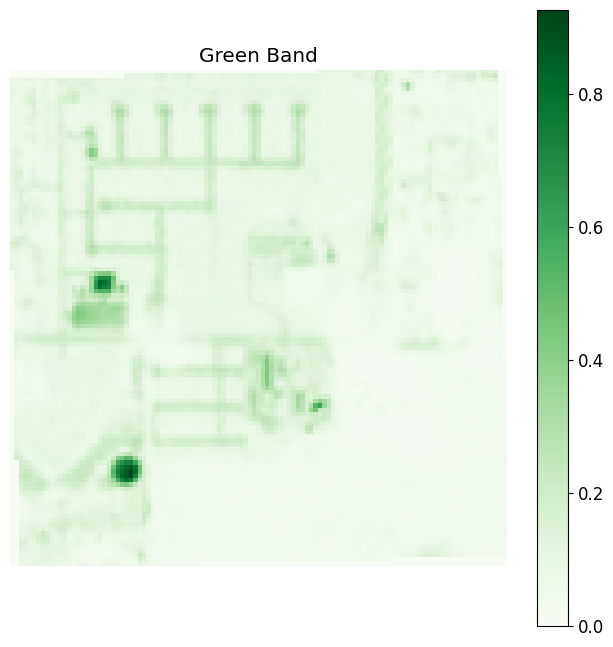

In [ ]:
show_band(green_b, title='Green Band', size = (8, 8), cmap='Greens')

NIR Band Shape:  (113, 113, 1)


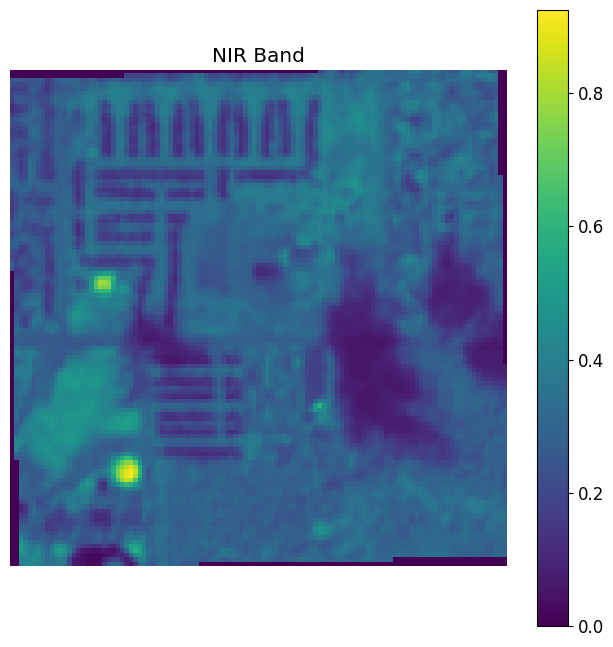

In [ ]:
show_band(nir_b, 'NIR Band', (8,8))

<ipython-input-36-2df102a2db49>:1: RuntimeWarning: invalid value encountered in divide
  ndwi2 = (green_b.astype(float)-nir_b.astype(float))/(green_b+nir_b)


NDWI Shape:  (113, 113, 1)


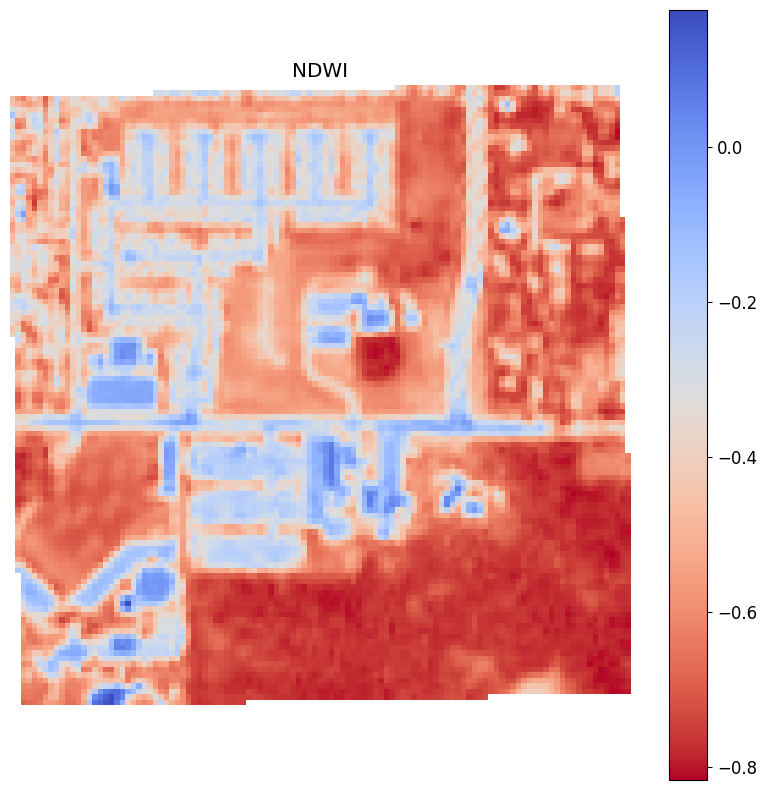

In [ ]:
ndwi2 = (green_b.astype(float)-nir_b.astype(float))/(green_b+nir_b)
show_band(ndwi2, title='NDWI', size=(10,10), cmap='coolwarm_r')
#plt.imsave('/content/drive/MyDrive/Colab Notebooks (1)/FYP/Images/NDWI_Pre.tiff',ndwi2[0])

In [ ]:
import numpy as np
from numpy import nan_to_num, subtract, add, divide, multiply
from osgeo import gdal, gdalconst
#from gdal import GetDriverByName

In [ ]:
b4 = rio.open(all_sentinel_bands[3])
b3 = rio.open(all_sentinel_bands[2])
b2 = rio.open(all_sentinel_bands[1])

In [ ]:
meta = b4.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)
with rio.open('/content/drive/MyDrive/Colab Notebooks (1)/FYP/Images/NDWI_Pre.tiff', 'w', **meta) as dst:
     dst.write(reshape_as_raster(ndwi2.astype(rio.float32)))

In [ ]:
ndwi_raster = rio.open('/content/drive/MyDrive/Colab Notebooks (1)/FYP/Images/NDWI_Pre.tiff')

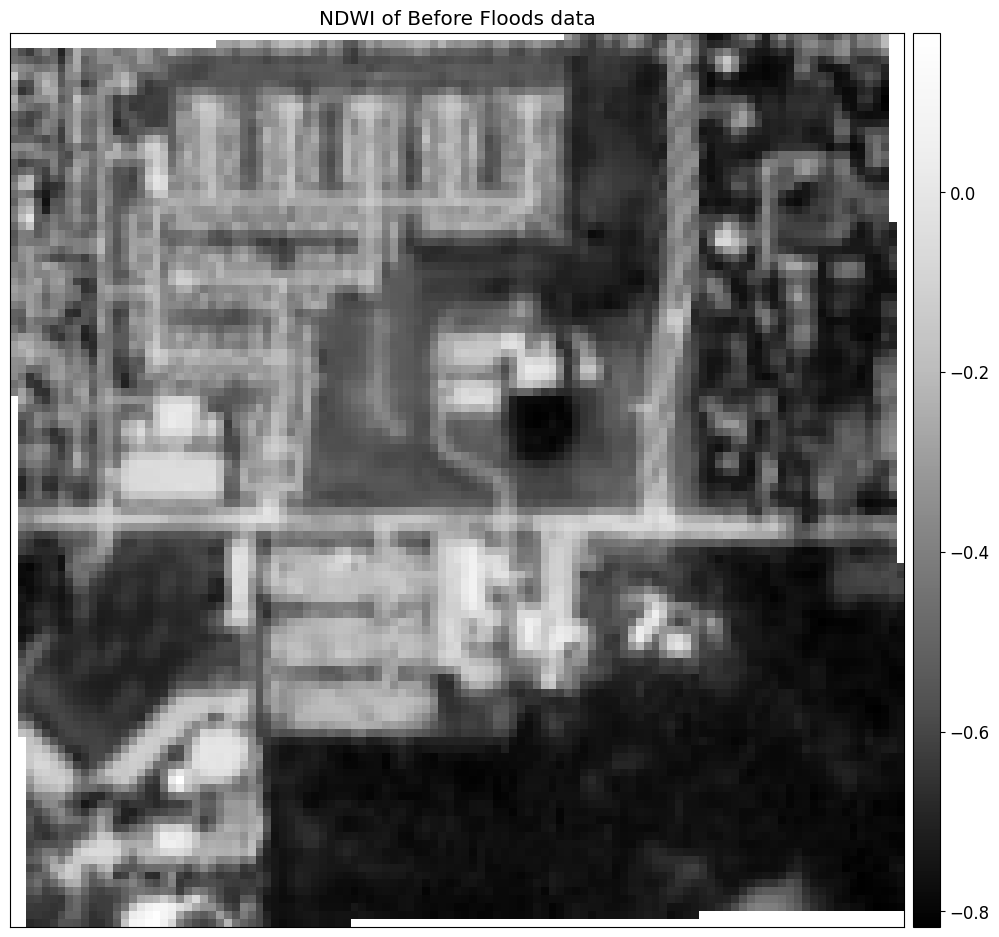

<Axes: title={'center': 'NDWI of Before Floods data'}>

In [ ]:
ep.plot_bands(ndwi_raster.read(), title='NDWI of Before Floods data')

Post Flood

In [ ]:
all_sentinel_bands_post_flood = glob(
    "/content/drive/MyDrive/Dataset/All_band_images/Post/08_30/*B[0-1]*.tiff")

all_sentinel_bands_post_flood.sort()
print(all_sentinel_bands_post_flood)

['/content/drive/MyDrive/Dataset/All_band_images/Post/08_30/2017-08-30-00_00_2017-08-30-23_59_Sentinel-2_L2A_B01_(Raw).tiff', '/content/drive/MyDrive/Dataset/All_band_images/Post/08_30/2017-08-30-00_00_2017-08-30-23_59_Sentinel-2_L2A_B02_(Raw).tiff', '/content/drive/MyDrive/Dataset/All_band_images/Post/08_30/2017-08-30-00_00_2017-08-30-23_59_Sentinel-2_L2A_B03_(Raw).tiff', '/content/drive/MyDrive/Dataset/All_band_images/Post/08_30/2017-08-30-00_00_2017-08-30-23_59_Sentinel-2_L2A_B04_(Raw).tiff', '/content/drive/MyDrive/Dataset/All_band_images/Post/08_30/2017-08-30-00_00_2017-08-30-23_59_Sentinel-2_L2A_B05_(Raw).tiff', '/content/drive/MyDrive/Dataset/All_band_images/Post/08_30/2017-08-30-00_00_2017-08-30-23_59_Sentinel-2_L2A_B06_(Raw).tiff', '/content/drive/MyDrive/Dataset/All_band_images/Post/08_30/2017-08-30-00_00_2017-08-30-23_59_Sentinel-2_L2A_B07_(Raw).tiff', '/content/drive/MyDrive/Dataset/All_band_images/Post/08_30/2017-08-30-00_00_2017-08-30-23_59_Sentinel-2_L2A_B08_(Raw).tiff',

In [ ]:
# run once, only to generate the RGB composite image.

af_b4 = rio.open(all_sentinel_bands_post_flood[3])
af_b3 = rio.open(all_sentinel_bands_post_flood[2])
af_b2 = rio.open(all_sentinel_bands_post_flood[1])


# Create an RGB image
with rio.open('/content/drive/MyDrive/Colab Notebooks (1)/FYP/Images/RGBImage.tiff','w',driver='Gtiff', width=af_b4.width, height=af_b4.height,
              count=3,crs=af_b4.crs,transform=af_b4.transform, dtype=af_b4.dtypes[0]) as rgb_af:
    rgb_af.write(af_b4.read(1),1)
    rgb_af.write(af_b3.read(1),2)
    rgb_af.write(af_b2.read(1),3)
    rgb_af.close()

In [ ]:
with rio.open('/content/drive/MyDrive/Colab Notebooks (1)/FYP/Images/RGBImage.tiff') as rgb_af:
  data_af = rgb_af.read()

data_af.shape

(3, 113, 113)

In [ ]:
with rio.open(all_sentinel_bands_post_flood[2]) as  f1:
    post_f_green_b = reshape_as_image(f1.read())

with rio.open(all_sentinel_bands_post_flood[7]) as  f2:
    post_f_nir_b = reshape_as_image(f2.read())

Green Band Shape:  (113, 113, 1)


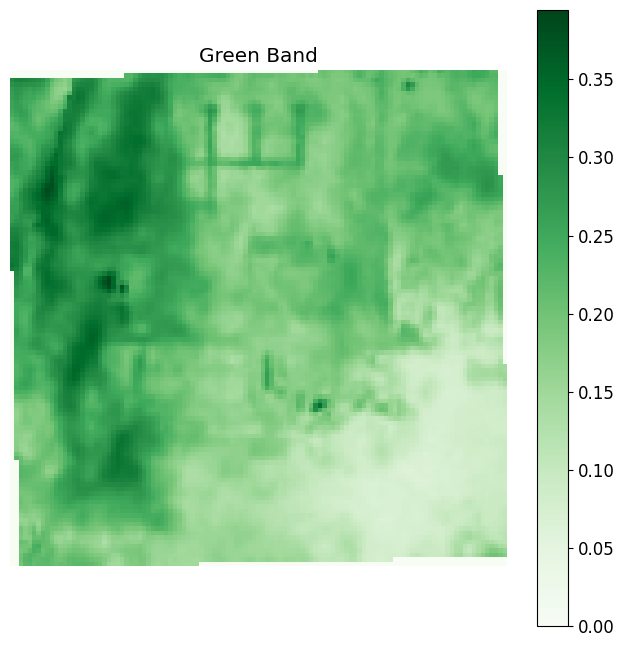

NIR Band Shape:  (113, 113, 1)


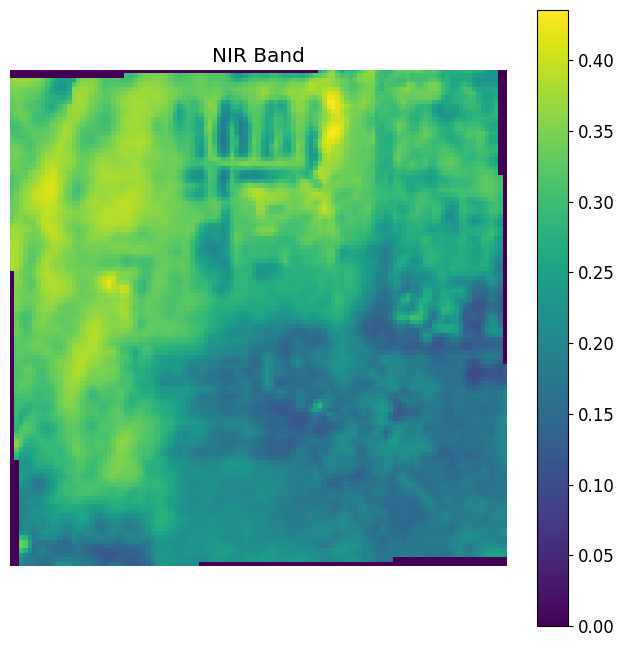

In [ ]:
show_band(post_f_green_b, title='Green Band', size = (8, 8), cmap='Greens')

show_band(post_f_nir_b, 'NIR Band', (8,8))

In [ ]:
ndwi_af = (post_f_green_b.astype(float)-post_f_nir_b.astype(float))/(post_f_green_b+post_f_nir_b)

<ipython-input-48-52f9dbc4c890>:1: RuntimeWarning: invalid value encountered in divide
  ndwi_af = (post_f_green_b.astype(float)-post_f_nir_b.astype(float))/(post_f_green_b+post_f_nir_b)


NDWI After Flood Shape:  (113, 113, 1)


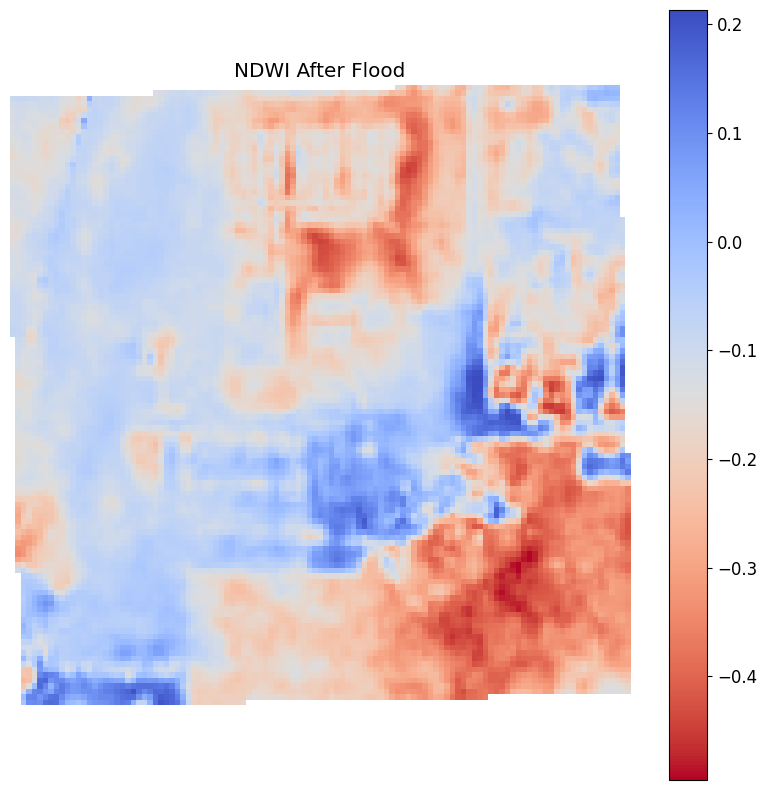

In [ ]:
show_band(ndwi_af, title='NDWI After Flood', size=(10,10), cmap='coolwarm_r')

In [ ]:
meta = af_b4.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)
with rio.open('/content/drive/MyDrive/Colab Notebooks (1)/FYP/Images/NDWI_Post.tiff', 'w', **meta) as dst:
     dst.write(reshape_as_raster(ndwi_af.astype(rio.float32)))

In [ ]:
ndwi_raster_af = rio.open('/content/drive/MyDrive/Colab Notebooks (1)/FYP/Images/NDWI_Post.tiff')

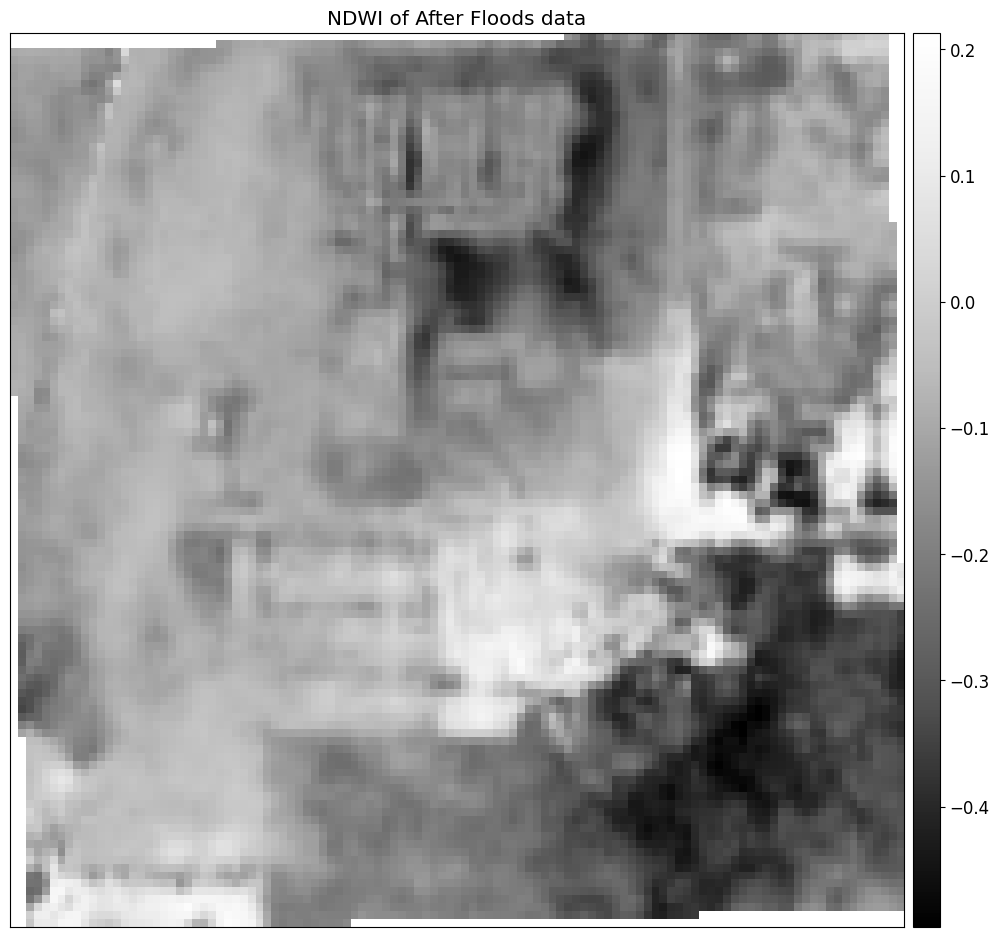

<Axes: title={'center': 'NDWI of After Floods data'}>

In [ ]:
ep.plot_bands(ndwi_raster_af.read(), title='NDWI of After Floods data')

In [ ]:
ndwi_af = ndwi_raster_af.read()

In [ ]:
import numpy as np
mask_af = ndwi_af < 0.0

In [ ]:
mask = mask_af.astype(int)

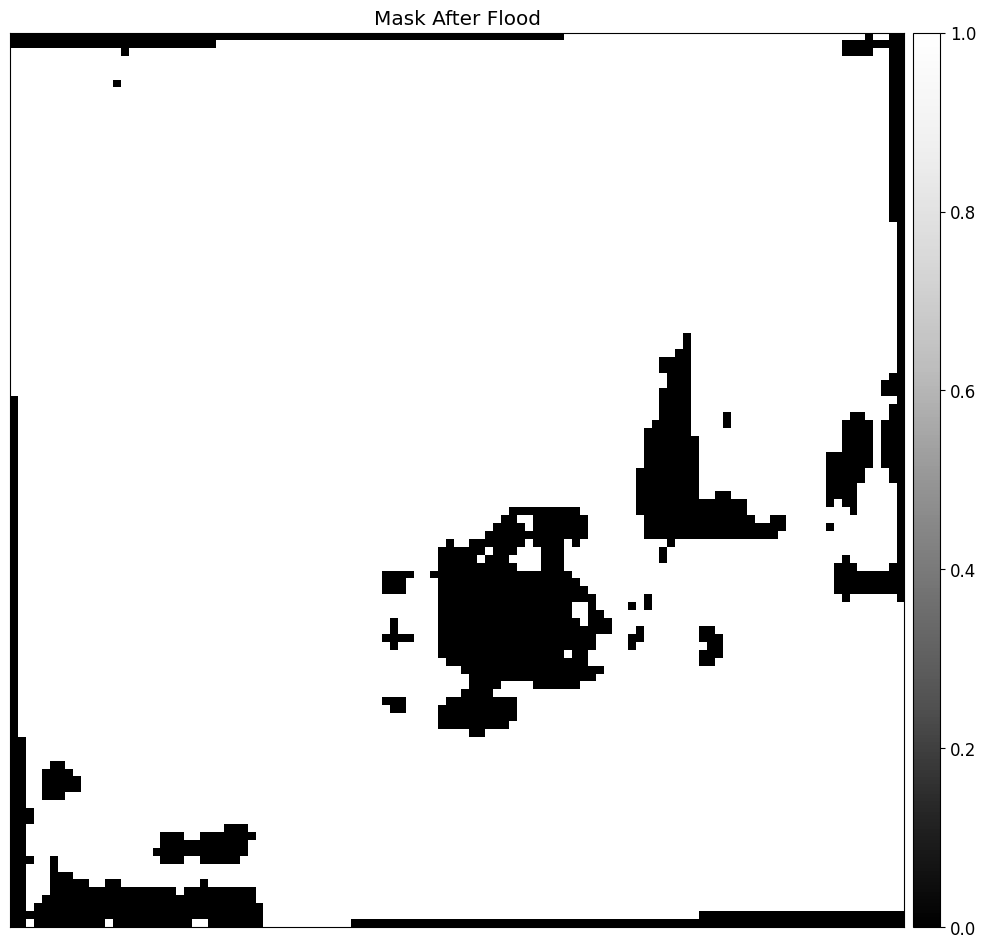

<Axes: title={'center': 'Mask After Flood'}>

In [ ]:
ep.plot_bands(mask_af, title='Mask After Flood')

In [ ]:
# Read the saved before flood
ndwi_raster = rio.open('/content/drive/MyDrive/Colab Notebooks (1)/FYP/Images/NDWI_Pre.tiff')
ndwi = ndwi_raster.read()

In [ ]:
mask = ndwi < 0.0

mask = mask.astype(int)

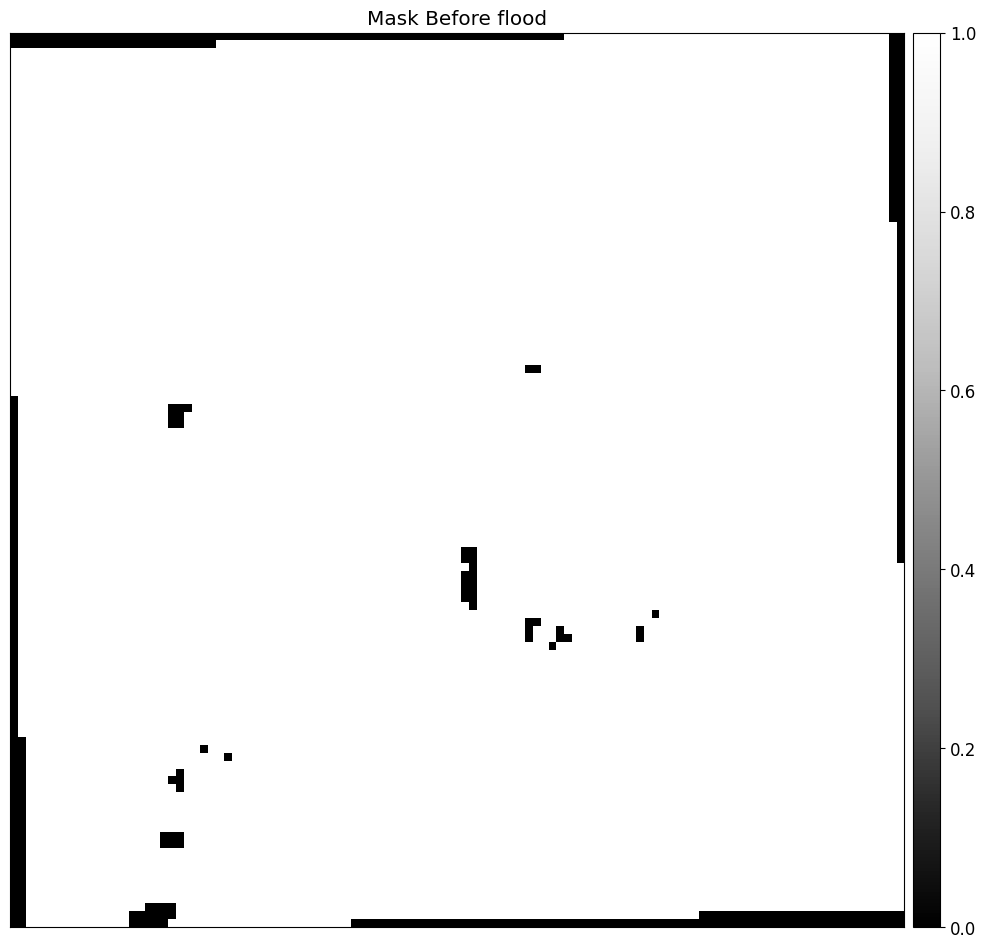

<Axes: title={'center': 'Mask Before flood'}>

In [ ]:
ep.plot_bands(mask, title = 'Mask Before flood')

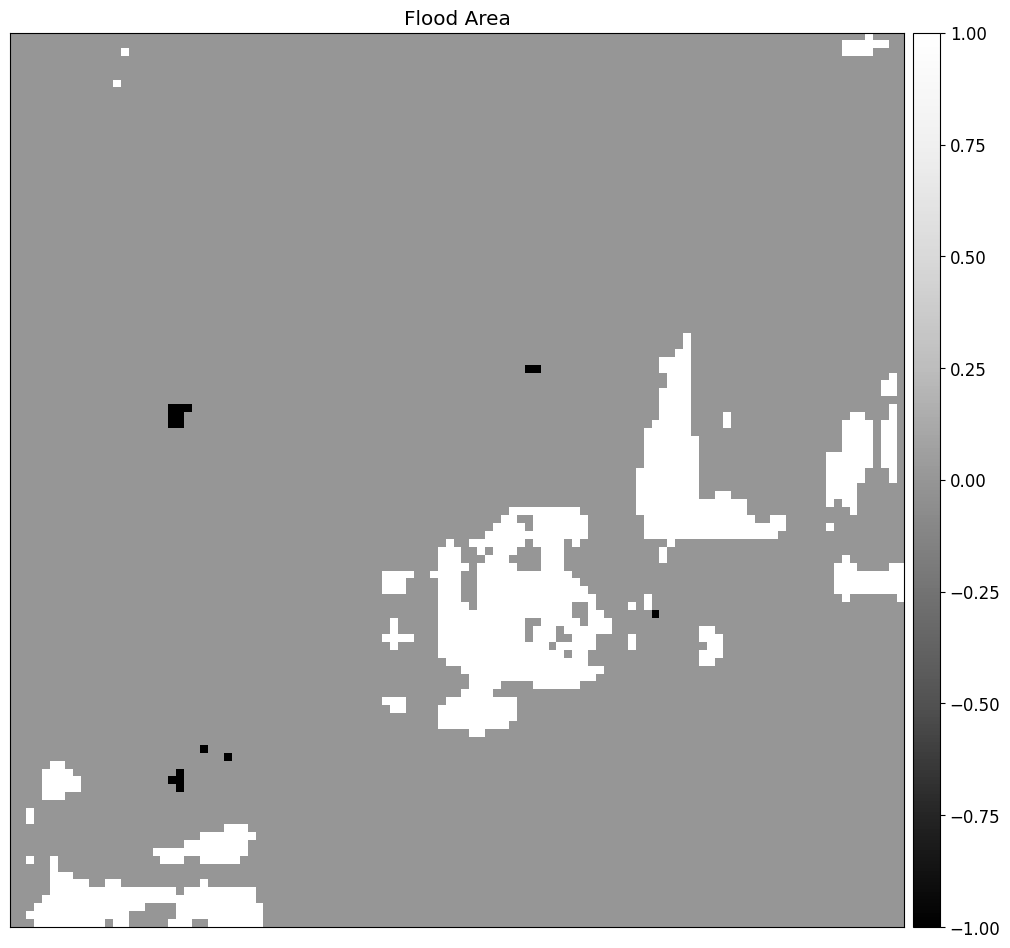

<Axes: title={'center': 'Flood Area'}>

In [ ]:
resulted_mask = mask - mask_af
ep.plot_bands(resulted_mask, title='Flood Area')

In [ ]:
# replace -1 with 0

resulted_mask[resulted_mask == -1] = 0

# replace values > 0 with 1
resulted_mask[resulted_mask > 0] = 1

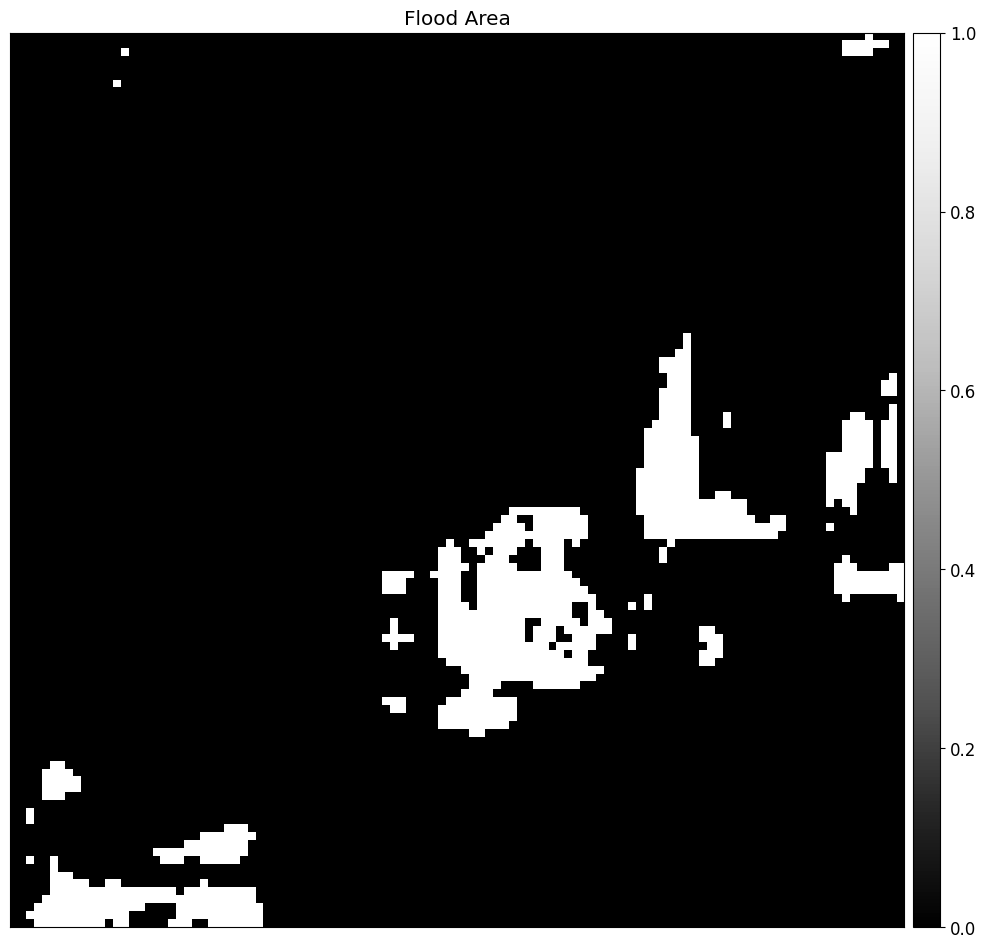

<Axes: title={'center': 'Flood Area'}>

In [ ]:
ep.plot_bands(resulted_mask, title='Flood Area')

In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/drive/MyDrive/Colab Notebooks (1)/FYP/Images/Flood.tiff")
n_white_pix = np.sum(resulted_mask == 1)
print('Number of Flooded pixels:', n_white_pix)
width, height = image.size
total = width*height
print('Number of Total pixels:',total )
flooded_Ratio = n_white_pix/total
print('Flooded Pixel Ratio:',flooded_Ratio)



Number of Flooded pixels: 935
Number of Total pixels: 12769
Flooded Pixel Ratio: 0.07322421489544992


In [ ]:
with rio.open('/content/drive/MyDrive/Colab Notebooks (1)/FYP/Images/Flood.tiff', 'w', driver='GTiff', dtype=rio.float32, width= resulted_mask.shape[2] , height = resulted_mask.shape[1], count=1) as gt:
     gt.write(resulted_mask.astype(rio.float32))

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
